In [15]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

In [3]:
# LOAD in fixed simulation parameters
sim_z = np.loadtxt('/Users/kulkarniad/muram/z.csv')
wl = fits.open('wl.fits')[0].data
NLAMBDA = 472
NZ = 64
NX = 50
NY = 50

#GLOBAL VARIABLES
TRT = 2.0*np.sqrt(2)  # 2 sqrt(2)
Aij = 28180897.721018 # straight out of RH from line->Aji 
                      #note that this is a factor 5 different from NIST

In [4]:
#find indices of strontium wl
jumps = np.where(np.diff(wl)>10)
ni = jumps[0][0] + 1
nf = jumps[0][1] + 1

In [5]:
# Create collision depolarization cube.
# Data based on dashed line in Figure 6 of DPA
def load_depol_array():
    data = pd.read_csv('depol.csv') # copy of Figure 6 of aleman and trujillo bueno
    z = data.iloc[:,0]*1e3 # z is in units of km
    delta = data.iloc[:,1] # delta is unitless
    delta_interp = interp1d(z,delta,fill_value= 'extrapolate')
    delta_array = delta_interp(sim_z)
    delta_cube = np.zeros((NZ,NY,NX))
    # Interpolate this function over MURaM z values
    for i in range(NX):
        for j in range(NY):
            delta_cube[:,j,i] = delta_array
    return delta_cube

In [6]:
d2u = load_depol_array()

Text(0, 0.5, '$\\delta_u^{(2)}$')

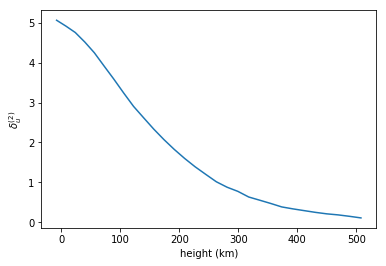

In [7]:
plt.plot(sim_z[:30],d2u[:30,0,0])
plt.xlabel('height (km)')
plt.ylabel('$\delta_u^{(2)}$')

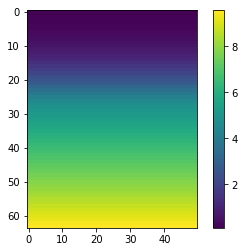

In [8]:
plt.imshow(d2u[:,:,32])
plt.colorbar()

In [9]:
class Opacity:
    def __init__(self,dir_loc):        
        data = fits.open(dir_loc+'opac_l.fits')
        self.opac_l = data[0].data
        data = fits.open(dir_loc+'opac_c.fits')
        self.opac_c = data[0].data

        data = fits.open(dir_loc+'emis_l.fits')
        self.emis_l = data[0].data
        data = fits.open(dir_loc+'emis_c.fits')
        self.emis_c = data[0].data
            

In [10]:
def epsilon(dir_loc):
    cij = np.loadtxt(dir_loc+'Cij8.txt').reshape(NZ,NY,NX)
    return cij/(cij+Aij)
    

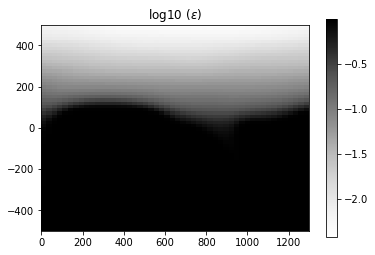

In [11]:
eps_small = epsilon('small/')
eps_smoothr = epsilon('smooth_reconstruct//')


plt.imshow(np.log10(eps_small[:,10,:]),cmap='Greys',extent=[0,1300,-500,500])
plt.colorbar()
plt.title('log10 ($ \epsilon $)')
plt.show()

$\varepsilon$ ranges from $\sim 1$ down low in the atmosphere to less than $0.01$ near the top of the atmosphere

In [12]:
class Sphr_tensors:
    def __init__(self,dir_loc):
        # spherical J tensors
        self.j00 = np.loadtxt(dir_loc+'J00.txt').reshape(NZ,NY,NX)
        self.j20 = np.loadtxt(dir_loc+'J20.txt').reshape(NZ,NY,NX)
        self.imj21 = np.loadtxt(dir_loc+'imJ21.txt').reshape(NZ,NY,NX)
        self.imj22 = np.loadtxt(dir_loc+'imJ22.txt').reshape(NZ,NY,NX)
        self.rej21 = np.loadtxt(dir_loc+'reJ21.txt').reshape(NZ,NY,NX)
        self.rej22 = np.loadtxt(dir_loc+'reJ22.txt').reshape(NZ,NY,NX)

In [13]:
class Source_function:
    def __init__(self,dir_loc):
        
        st = Sphr_tensors(dir_loc)       
        eps = epsilon(dir_loc)
        
        # opacity parameters
        self.opcty = Opacity(dir_loc)        
        self.r = self.opcty.opac_l / (self.opcty.opac_l  + self.opcty.opac_c )
        self.source_l = self.opcty.emis_l/self.opcty.opac_l
        self.source_c = self.opcty.emis_c/self.opcty.opac_c
        
        # create optical depth arrays
        total_opac = self.opcty.opac_l  + self.opcty.opac_c
        self.tau_cube = np.zeros((NLAMBDA,NZ,NY,NX))
        for l in range(NLAMBDA):
            for i in range(NX):
                for j in range(NY):
                    self.tau_cube[l,:,j,i] = cumtrapz(total_opac[l,:,j,i], x=sim_z*1e3,initial=-1e-5) * (-1.0)
            
    
        self.s00 = self.source_l # define this to be the line source function
        
        # eq 5 of del pino aleman (DPA)
        self.s20   = (1-eps)/(1+d2u*(1-eps)) * st.j20
        self.res21 = (1-eps)/(1+d2u*(1-eps)) * st.rej21
        self.res22 = (1-eps)/(1+d2u*(1-eps)) * st.rej22        
        self.ims21 = (1-eps)/(1+d2u*(1-eps)) * st.imj21 * (-1.0)
        self.ims22 = (1-eps)/(1+d2u*(1-eps)) * st.imj22 * (-1.0)
        
    # Line source functions 
    #(eq 6 of DPA)
    def si_line(self,mu,azi):
        c1 = 1/TRT*(3*mu**2 - 1)
        c2 = np.sqrt(3)*mu*np.sqrt(1-mu**2)
        c3 = (np.sqrt(3)/2) * (1-mu**2)        

        out = self.s00 + c1*self.s20 
        out-= c2*(self.res21*np.cos(azi)-self.ims21*np.sin(azi)) 
        out+= c3*(self.res22*np.cos(2*azi) - self.ims22*np.sin(2*azi)) 

        return out

    #(eq 7 of DPA)
    def sq_line(self,mu,azi):
        c1 = 3/TRT*(mu**2 - 1)
        c2 = np.sqrt(3)*mu*np.sqrt(1-mu**2)
        c3 = (np.sqrt(3)/2) * (1+mu**2)

        out = c1*self.s20 
        out-= c2*(self.res21*np.cos(azi)-self.ims21*np.sin(azi)) 
        out-= c3*(self.res22*np.cos(2*azi)-self.ims22*np.sin(2*azi))
        
        return out

    #(eq 8 of DPA)
    def su_line(self,mu,azi):
        c1 = np.sqrt(1-mu**2)
        
        out = c1*(self.res21*np.sin(azi) + self.ims21*np.cos(azi)) 
        out += mu*(self.res22*np.sin(2*azi) + self.ims22*np.cos(2*azi))

        out *= np.sqrt(3.0)
        return out
    
# Now Calculate source functions of I, Q U:         
    def source_i(self,mu,azi):
        return self.r*self.si_line(mu,azi) + (1-self.r)*self.source_c

    def source_q(self,mu,azi):
        return self.r*self.sq_line(mu,azi)  # check that some wierd broadcasting is not going on here!

    def source_u(self,mu,azi):
        return self.r*self.su_line(mu,azi) 

In [16]:
src_fnc = Source_function('small/')

Source funcs are loaded and ready to rumble!

###  Now apply formal solution to derived source functions

In [216]:
# FORMAL solver for vertical rays

def sc_formal_solver(I_upwind,delta,S_upwind,S_local):
 
    expd = np.exp(-delta)
    w_local = 1.0 - 1.0/delta * (1.0 - expd)
    w_upwind = -expd + 1.0/delta * (1.0 - expd)
 
    I_local = I_upwind * expd + w_local * S_local + w_upwind * S_upwind
 
    return I_local


def formal_3d(S,tau_cube):
    assert S.shape == (NLAMBDA, NZ, NY, NX), 'Source function must be a 4D cube'
    assert S.shape == (NLAMBDA, NZ, NY, NX), 'Tau must be a 4D cube'
    
    I_cube = np.zeros((NLAMBDA,NZ,NY,NX))
    I_cube[:,-1,:,:] = S[:,-1,:,:]  # Set S = I at bottom of atmosphere

    for l in range(NLAMBDA):
        for j in range(NY):
            for i in range(NX):
                for d in np.arange(NZ-2,-1,-1): # from bottom to top (d is decreasing)
                    dtau = tau_cube[l,d+1,j,i] - tau_cube[l,d,j,i]
                    I_cube[l,d,j,i] = sc_formal_solver(I_cube[l,d+1,j,i],dtau,S[l,d+1,j,i],S[l,d,j,i])
    
    return I_cube[:,0,:,:] # return emergent intensity


In [217]:
!pwd

/Users/kulkarniad/reconstruct_hanle/scattering_pol


# Synthesize polarization and save to fits file

In [219]:
#src_fnc = Source_function('small/')
#i_out = formal_3d(src_fnc.source_i(1.0,0.0),src_fnc.tau_cube)
#hdu = fits.PrimaryHDU(i_out)
#hdu.writeto('small_I.fits')

In [23]:
#src_fnc = Source_function('small/')
#i_out = formal_3d(src_fnc.source_q(1.0,0.0),src_fnc.tau_cube)
#hdu = fits.PrimaryHDU(i_out)
#hdu.writeto('small_Q.fits')

In [24]:
#src_fnc = Source_function('small/')
#i_out = formal_3d(src_fnc.source_u(1.0,0.0),src_fnc.tau_cube)
#hdu = fits.PrimaryHDU(i_out)
#hdu.writeto('small_U.fits')

In [25]:
#src_fnc = Source_function('smooth_reconstruct/')
#i_out = formal_3d(src_fnc.source_i(1.0,0.0),src_fnc.tau_cube)
#hdu = fits.PrimaryHDU(i_out)
#hdu.writeto('smooth_reconstruct_I.fits')

In [26]:
#src_fnc = Source_function('smooth_reconstruct/')
#i_out = formal_3d(src_fnc.source_q(1.0,0.0),src_fnc.tau_cube)
#hdu = fits.PrimaryHDU(i_out)
#hdu.writeto('smooth_reconstruct_Q.fits')

In [220]:
#src_fnc = Source_function('smooth_reconstruct/')
#i_out = formal_3d(src_fnc.source_u(1.0,0.0),src_fnc.tau_cube)
#hdu = fits.PrimaryHDU(i_out)
#hdu.writeto('smooth_reconstruct_U.fits')

In [221]:
i_out.shape

(472, 50, 50)

# Analyzing outputs

In [222]:
true_I = fits.open('small_I.fits')[0].data
true_Q = fits.open('small_Q.fits')[0].data
true_U = fits.open('small_U.fits')[0].data

recons_I = fits.open('smooth_reconstruct_I.fits')[0].data
recons_Q = fits.open('smooth_reconstruct_Q.fits')[0].data
recons_U = fits.open('smooth_reconstruct_U.fits')[0].data


In [321]:
def view_spectra(i,j):
    plt.subplots(figsize=(15, 15))

    plt.subplot(221)
    image = true_I[0]
    plt.imshow(image,cmap='hot')
    #plt.clim(0,5e-8)
    lenth = 10
    plt.arrow(0, 0,i, j,width = 0.1,head_length = 2.0,head_width = 2.0)
    plt.title('continuum intensity')
    plt.colorbar()

    plt.subplot(222)
    plt.plot(true_I[ni:nf,i,j])
    plt.xlabel('wavelengths')
    plt.ylabel('Intesity')
    plt.title('Intensity')

    plt.subplot(223)
    plt.plot(true_Q[ni:nf,i,j]/true_I[ni:nf,i,j])
    plt.xlabel('Wavelengths')
    plt.ylabel('Intesity')
    plt.title('Stokes Q/I')

    plt.subplot(224)
    plt.plot(true_U[ni:nf,i,j]/true_I[ni:nf,i,j])
    plt.xlabel('Wavelengths')
    plt.ylabel('Intesity')
    plt.title('Stokes U/I')
    plt.show()
    
    
    
    
def spatial_map(wl_index):
    plt.figure(figsize=(6,6))
    plt.imshow(true_I[0],cmap='hot')
    plt.title('Continuum Intensity ', fontsize=20)
    plt.clim(np.min(true_I[0]),np.max(true_I[0]))
    plt.colorbar()
    plt.show()

    
    plt.subplots(figsize=(20, 10))
    plt.subplot(121)
    Q_I = true_Q[wl_index]/true_I[wl_index]
    plt.title('Q/I', fontsize=30)
    plt.imshow(Q_I,cmap='bwr')
    plt.colorbar()
    plt.clim(-0.02,0.02)


    plt.subplot(122)
    U_I = true_U[wl_index]/true_I[wl_index]
    plt.title('U/I', fontsize=30)
    plt.imshow(U_I,cmap='bwr')
    plt.clim(-0.02,0.02)
    plt.colorbar()
    plt.show()


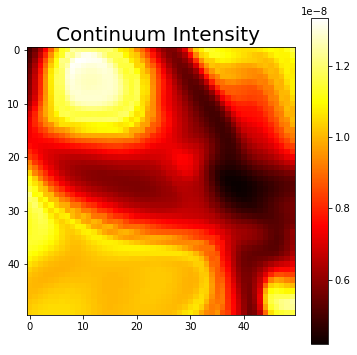

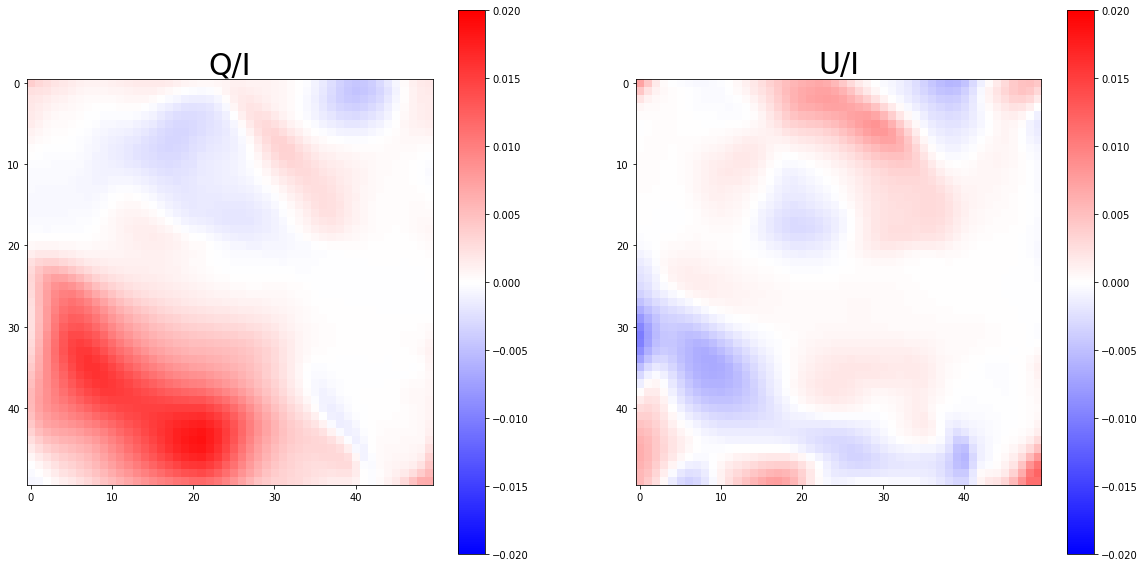

In [322]:
spatial_map(int((ni + nf)/2))

25 14


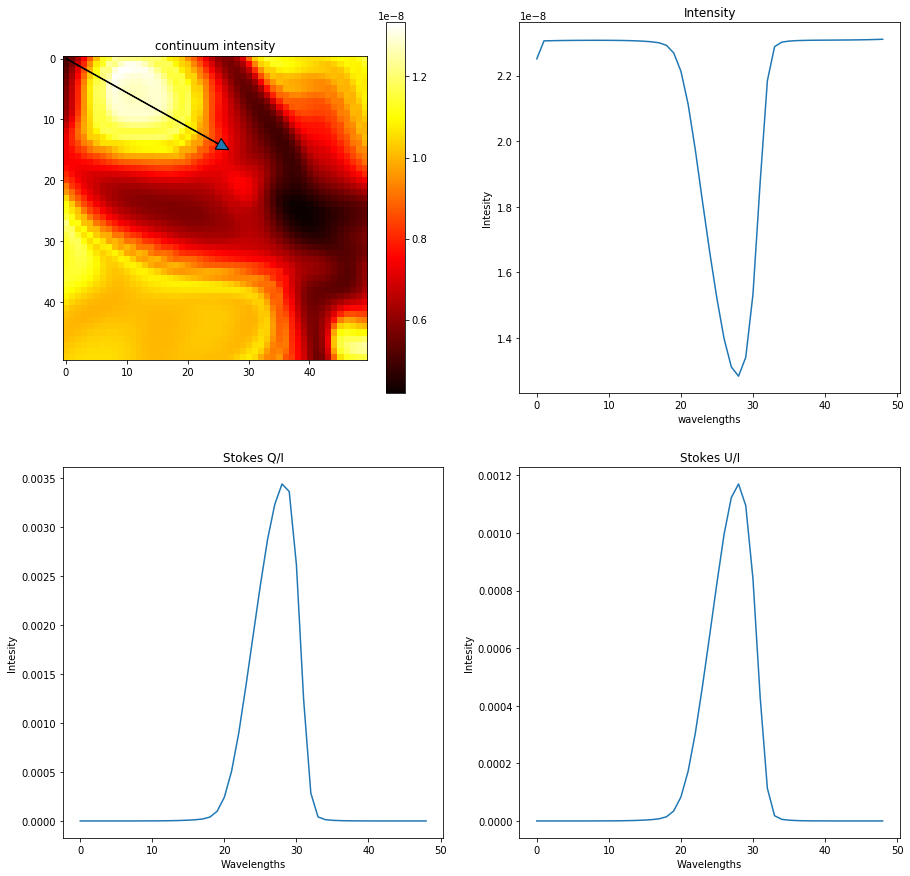

In [253]:
i = np.random.randint(50)
j = np.random.randint(50)
print(i,j)
view_spectra(i,j)


In [307]:
line_core = int((ni + nf)/2)

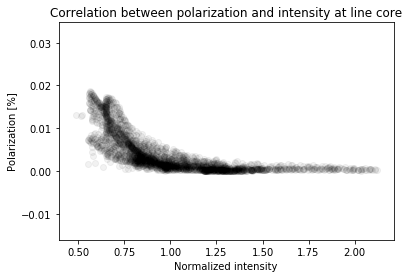

In [312]:
pol = np.sqrt(true_Q[line_core]**2 + true_U[line_core]**2)
pol /= true_I[line_core]

norm_I = true_I[line_core] / np.mean(true_I[line_core])

plt.scatter(norm_I,pol,alpha=0.05,color = 'black')
plt.title('Correlation between polarization and intensity at line core')
plt.xlabel('Normalized intensity')
plt.ylabel('Polarization [%]')
plt.show()


# Random stuff I'm experimenting with

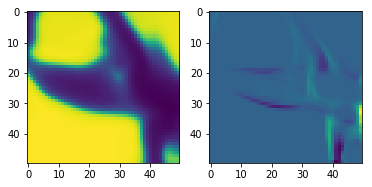

In [274]:
import matplotlib.pyplot as plt
import numpy as np

list1 = np.random.rand(10)*2.1
list2 = np.random.rand(10)*3.0

plt.subplot(1, 2, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plt.imshow(I_cube[30,30])
plt.subplot(1, 2, 2)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
plt.imshow(Q_cube[30,30])
plt.show()

In [275]:
U_cube.shape

(472, 64, 50, 50)

In [195]:
wl[25]

460.72841549080925

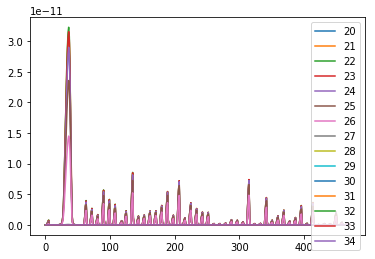

In [194]:
for i in np.arange(20,35):
    plt.plot(Q_cube[:,i,40,0],label = str(i))
    plt.legend()

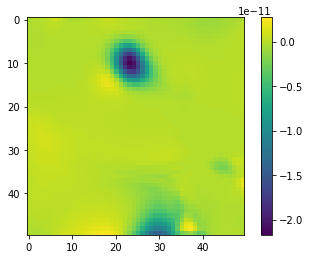

In [201]:
plt.
plt.imshow(Q_cube[25,0,:,:])
plt.colorbar()

In [198]:
Q_cube.shape

(472, 64, 50, 50)

# Comparing reconstructions with original atmosphere

In [28]:
true_I = fits.open('small_I.fits')[0].data
true_Q = fits.open('small_Q.fits')[0].data
true_U = fits.open('small_U.fits')[0].data

recons_I = fits.open('smooth_reconstruct_I.fits')[0].data
recons_Q = fits.open('smooth_reconstruct_Q.fits')[0].data
recons_U = fits.open('smooth_reconstruct_U.fits')[0].data


In [29]:
true_I.shape

(472, 50, 50)

# Scatterplots in intensity

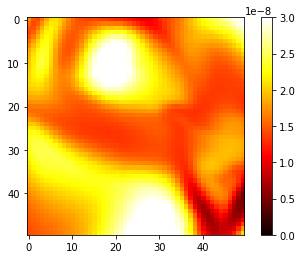

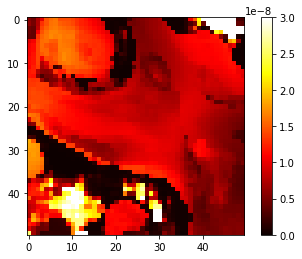

In [374]:
plt.imshow(true_I[int(ni+nf/2),0],cmap='hot')
plt.clim(0,3e-8)
plt.colorbar()
plt.show()
plt.imshow(recons_I[int(ni+nf/2),0],cmap='hot')
plt.clim(0,3e-8)
plt.colorbar()
plt.show()

Text(0.5, 0, 'true')

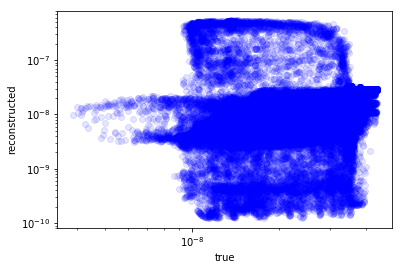

In [367]:
plt.loglog(true_I[ni:nf,0].flatten(),recons_I[ni:nf,0].flatten(),'bo',alpha=0.1)
plt.ylabel('reconstructed')
plt.xlabel('true')
#plt.ylim(0,5e-7)
#plt.xlim(0,1e-7)

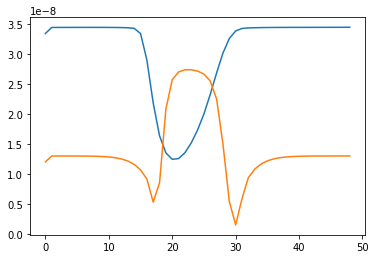

In [451]:
i = np.random.randint(0,50)
j = np.random.randint(0,50)

plt.plot(true_I[ni:nf,0,i,j])
plt.plot(recons_I[ni:nf,0,i,j])

# synthesized intensities look quite different ...

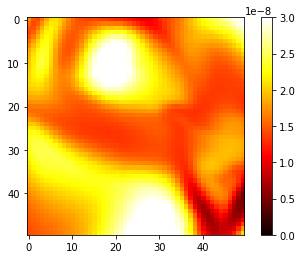

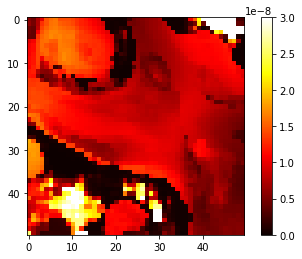

In [431]:
plt.imshow(true_I[int(ni+nf/2),0],cmap='hot')
plt.clim(0,3e-8)
plt.colorbar()
plt.show()
plt.imshow(recons_I[int(ni+nf/2),0],cmap='hot')
plt.clim(0,3e-8)
plt.colorbar()
plt.show()

# Now look at Q

In [ ]:
plt.scatter(true_U[ni:nf,0,2,1])

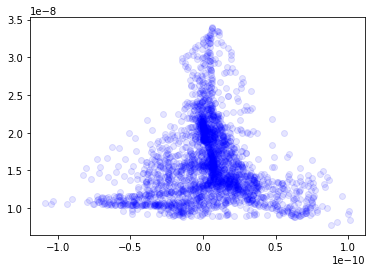

In [472]:
plt.plot(true_U[int(ni*0.5 + nf*0.5),0,:,:],
         true_I[int(ni*0.5 + nf*0.5),0,:,:],'bo',alpha = 0.1)
plt.show()

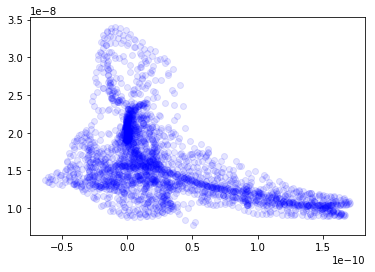

In [473]:
plt.plot(true_Q[int(ni*0.5 + nf*0.5),0,:,:],
         true_I[int(ni*0.5 + nf*0.5),0,:,:],'bo',alpha = 0.1)
plt.show()

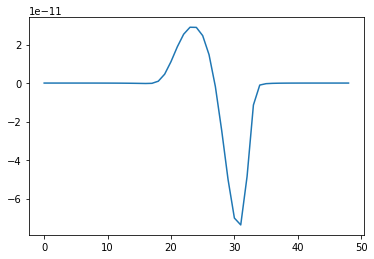

In [448]:
plt.plot(true_Q[ni:nf,0,3,1])

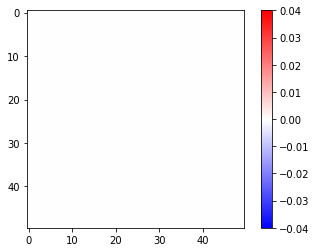

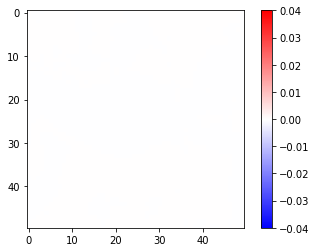

In [436]:
plt.imshow(true_Q[int(ni+nf/2),0],cmap='')
plt.clim(-0.04,0.04)
plt.colorbar()
plt.show()
plt.imshow(recons_Q[int(ni+nf/2),0],cmap='bwr')
plt.colorbar()
plt.clim(-0.04,0.04)
plt.show()

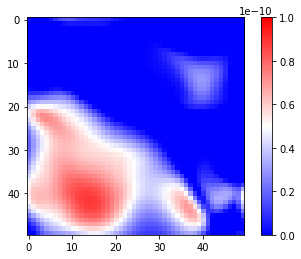

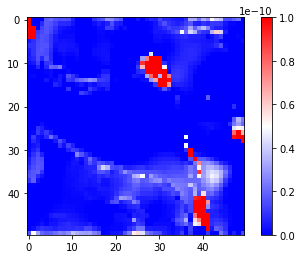

In [475]:
plt.imshow(true_Q[int(ni+nf/2),0],cmap='bwr')
plt.clim(0.0,1e-10)
plt.colorbar()
plt.show()
plt.imshow(recons_Q[int(ni+nf/2),0],cmap='bwr')
plt.colorbar()
plt.clim(0,1e-10)
plt.show()

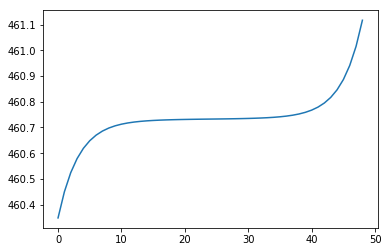

In [350]:
plt.plot(wl[ni:nf])

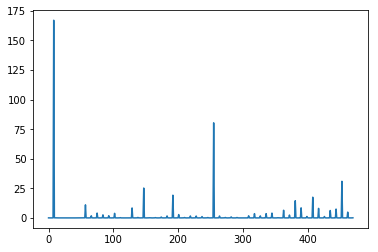

In [333]:
plt.plot(np.diff(wl))

In [334]:
np.where(np.diff(wl)>10)

(array([  8,  57, 147, 192, 255, 381, 408, 453]),)

In [ ]:
plt.scatter(true_I[:])